In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
from qasvm.datasets import Toy2DLinearLoader, Sklearn_DataLoader, Toy2DXORLoader, ToyBlochSphereLoader
from qasvm.preprocessing import DataMultiScaler, DataScaler
from qasvm.classifier import BinarySVM
from qasvm.kernel import Kernel
from sklearn.datasets import make_circles, make_moons, load_breast_cancer
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from qasvm.circuits.classifier import QASVM, BlochSphereQASVM
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.ibmqbackend import IBMQBackend

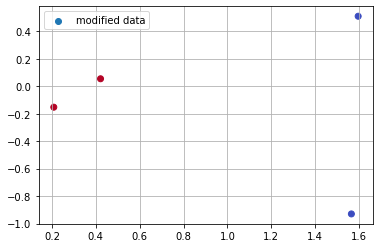

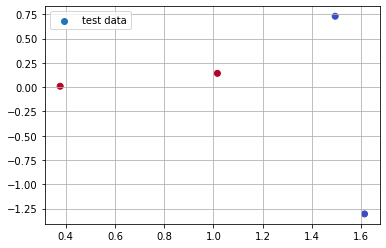

In [4]:

dl = ToyBlochSphereLoader(gap=np.pi/8)
X, y = dl(4, 0.1)
Xt, yt = dl(4, 0.1)
plt.scatter(X[:,0], X[:,1], marker='o', c=y, cmap=plt.cm.coolwarm, label='modified data')
plt.grid()
plt.legend()
plt.figure()
plt.scatter(Xt[:,0], Xt[:,1], marker='o', c=yt, cmap=plt.cm.coolwarm, label='test data')
plt.grid()
plt.legend()

In [5]:
svm11 = BinarySVM(Kernel('Pow2'), C=None, mutation='REDUCED_QASVM', k=0.1)
svm12 = BinarySVM(Kernel('Pow2'), C=1e2, mutation='REDUCED_QASVM', k=0.1)
svm21 = BinarySVM(Kernel('Pow2'), C=1e0, mutation='REDUCED_QASVM', k=0.1)
svm22 = BinarySVM(Kernel('Pow2'), C=1e-10, mutation='REDUCED_QASVM', k=0.1)

svms = [[svm11, svm12], [svm21, svm22]]
for i in range(2):
    for j in range(2):
        svms[i][j].fit(X, y)

1.0 optimal
1.0 optimal
1.0 optimal
0.5 optimal


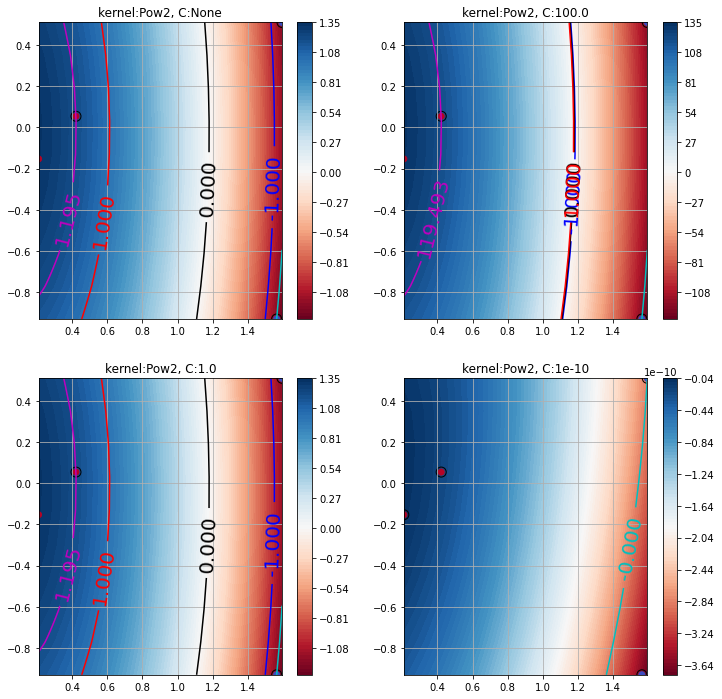

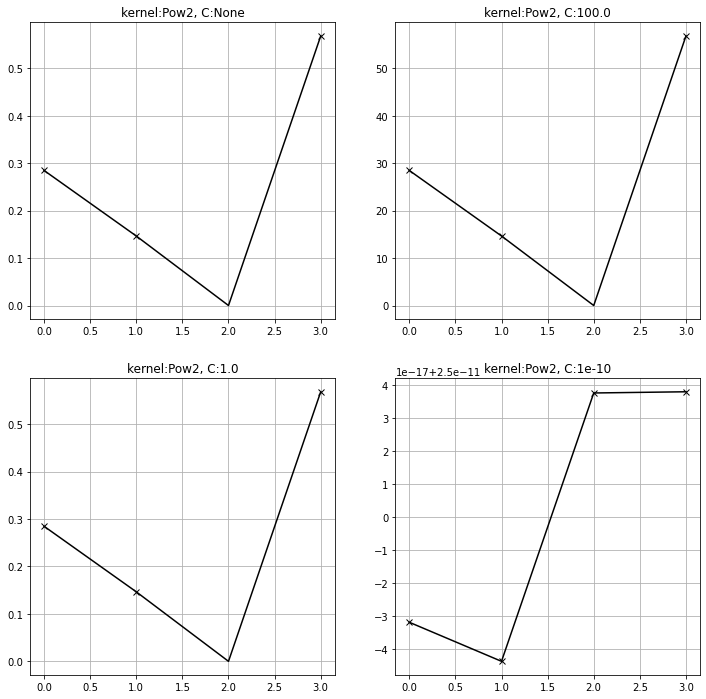

In [6]:
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 12))
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    for j in range(2):
        svms[i][j].plot_boundary(ax=axes1[i][j], fig=fig1)
        axes1[i][j].set_title('kernel:{:}, C:{:}'.format(svms[i][j].kernel, svms[i][j].C))
        svms[i][j].plot('alpha', ax=axes2[i][j])
        axes2[i][j].set_title('kernel:{:}, C:{:}'.format(svms[i][j].kernel, svms[i][j].C))
        print(svms[i][j].accuracy(Xt, yt), svms[i][j].status)

In [7]:
opt = SLSQP()
#feature_map = TwoLocal(1, ['ry', 'rz'], reps=1, skip_final_rotation_layer=True)
from qiskit.circuit import ParameterVector, QuantumCircuit
p = ParameterVector('theta', 2)
qc = QuantumCircuit(1, name='u3')
qc.u3(p[0], p[1], 0, 0)
feature_map = qc
var_form = EfficientSU2(2)
qi = QuantumInstance(QasmSimulator(), shots=2**14)

qasvm = QASVM(var_form=var_form, feature_map=feature_map, optimizer=opt, training_data=X, training_label=y, quantum_instance=qi, C=1, k=0.1).dual
qasvm.second_order_circuit.draw()

┌───┐                                                              »
 a_0: ───┤ H ├──────────────────────────────────────────────────────────────»
      ┌──┴───┴───┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
 i_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
      ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
 i_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
      └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
xi_0: ──────────────────────────────────────────────────────────────────────»
                                                                            »
yi_0: ──────────────────────────────────────────────────────────────────────»
      ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
 j_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
      ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
 j_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
      └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
xj_0: ──────────────────────────────────────────────────────────────────────»
                                                                            »
yj_0: ──────────────────────────────────────────────────────────────────────»
                                                                            »
 c: 3/══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                         »
« a_0: ───────────────────────────────────────────────────────────────────»
«      ┌───────────┐     ┌───────────┐┌───────────┐                       »
« i_0: ┤ RZ(θ[10]) ├──■──┤ RY(θ[12]) ├┤ RZ(θ[14]) ├──o─────■─────o─────o──»
«      ├───────────┤┌─┴─┐├───────────┤├───────────┤  │     │     │     │  »
« i_1: ┤ RZ(θ[11]) ├┤ X ├┤ RY(θ[13]) ├┤ RZ(θ[15]) ├──o─────o─────■─────■──»
«      └───────────┘└───┘└───────────┘└───────────┘┌─┴──┐┌─┴──┐┌─┴──┐  │  »
«xi_0: ────────────────────────────────────────────┤ u3 ├┤ u3 ├┤ u3 ├──┼──»
«                                                  └────┘└────┘└────┘┌─┴─┐»
«yi_0: ──────────────────────────────────────────────────────────────┤ X ├»
«      ┌───────────┐     ┌───────────┐┌───────────┐                  └───┘»
« j_0: ┤ RZ(θ[10]) ├──■──┤ RY(θ[12]) ├┤ RZ(θ[14]) ├──o─────■─────o─────o──»
«      ├───────────┤┌─┴─┐├───────────┤├───────────┤  │     │     │     │  »
« j_1: ┤ RZ(θ[11]) ├┤ X ├┤ RY(θ[13]) ├┤ RZ(θ[15]) ├──o─────o─────■─────■──»
«      └───────────┘└───┘└───────────┘└───────────┘┌─┴──┐┌─┴──┐┌─┴──┐  │  »
«xj_0: ────────────────────────────────────────────┤ u3 ├┤ u3 ├┤ u3 ├──┼──»
«                                                  └────┘└────┘└────┘┌─┴─┐»
«yj_0: ──────────────────────────────────────────────────────────────┤ X ├»
«                                                                    └───┘»
« c: 3/═══════════════════════════════════════════════════════════════════»
«                                                                         »
«                    ┌───┐┌─┐
« a_0: ────────────■─┤ H ├┤M├
«                  │ └───┘└╥┘
« i_0: ──■─────■───┼───────╫─
«        │     │   │       ║ 
« i_1: ──■─────■───┼───────╫─
«      ┌─┴──┐  │   │       ║ 
«xi_0: ┤ u3 ├──┼───X───────╫─
«      └────┘┌─┴─┐ │  ┌─┐  ║ 
«yi_0: ──────┤ X ├─┼──┤M├──╫─
«            └───┘ │  └╥┘  ║ 
« j_0: ──■─────■───┼───╫───╫─
«        │     │   │   ║   ║ 
« j_1: ──■─────■───┼───╫───╫─
«      ┌─┴──┐  │   │   ║   ║ 
«xj_0: ┤ u3 ├──┼───X───╫───╫─
«      └────┘┌─┴─┐┌─┐  ║   ║ 
«yj_0: ──────┤ X ├┤M├──╫───╫─
«            └───┘└╥┘  ║   ║ 
« c: 3/════════════╩═══╩═══╩═
«                  2   1   0

In [8]:
bqasvm = BlochSphereQASVM(var_form=var_form, optimizer=opt, training_data=X, training_label=y, quantum_instance=qi, C=10, k=0.1).primal
bqasvm.run()
bqasvm.accuracy(X, y)

0.5

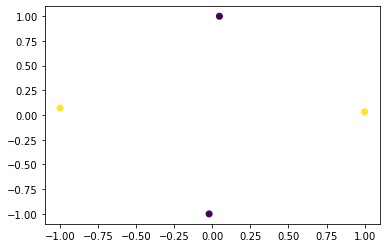

In [9]:
from qasvm.datasets import Toy2DXORLoader
dl = Toy2DXORLoader(0, 1/2, 2/2, 3/2)
X, y = dl(1, 0.1)
plt.scatter(X[:,0], X[:,1], c=y)

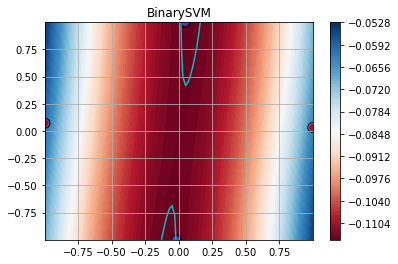

In [10]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), C=None, k=0.1, mutation='REDUCED_uniform_QASVM')
svm.fit(X, y)
svm.plot_boundary()


In [11]:
from qasvm.circuits.classifier import UniformQASVM
qasvm = UniformQASVM(feature_map = feature_map, training_data = X, training_label = y, quantum_instance=qi, C=None, k=0.1)
qasvm.run()
qasvm.accuracy(X, y)

0.5

In [12]:
qasvm.classifier_circuit.draw()

┌───┐                                            ┌───┐┌─┐
 a_0: ───────┤ H ├──────────────────────────────────────────■─┤ H ├┤M├
             ├───┤                                          │ └───┘└╥┘
 i_0: ───────┤ H ├─────────o─────o────■─────o─────o────■────┼───────╫─
             ├───┤         │     │    │     │     │    │    │       ║ 
 i_1: ───────┤ H ├─────────o─────o────o─────■─────■────■────┼───────╫─
             └───┘       ┌─┴──┐  │  ┌─┴──┐┌─┴──┐  │  ┌─┴──┐ │       ║ 
xi_0: ───────────────────┤ u3 ├──┼──┤ u3 ├┤ u3 ├──┼──┤ u3 ├─X───────╫─
                         └────┘┌─┴─┐└────┘└────┘┌─┴─┐└┬─┬─┘ │       ║ 
yi_0: ─────────────────────────┤ X ├────────────┤ X ├─┤M├───┼───────╫─
      ┌─────────────────┐      └───┘            └───┘ └╥┘   │       ║ 
xj_0: ┤ U3(𝒳[0],𝒳[1],0) ├──────────────────────────────╫────X───────╫─
      └─────────────────┘                              ║            ║ 
 c: 2/═════════════════════════════════════════════════╩════════════╩═
                                                       1            0

In [13]:
X = np.random.rand(4, 2)
print(qasvm.f(X))
print(svm.f(X))

[8.89746094 7.8182373  7.89355469 8.54650879]
[-0.11345675 -0.08686149 -0.08653085 -0.10223696]


In [14]:
qasvm._construct_first_order_circuit(X[0]).draw()

┌───┐                                            »
 a_0: ────────────────────┤ H ├────────────────────────────────────────────»
                          ├───┤                                            »
 i_0: ────────────────────┤ H ├───────────────────────o─────o────■─────o───»
                          ├───┤                       │     │    │     │   »
 i_1: ────────────────────┤ H ├───────────────────────o─────o────o─────■───»
                          └───┘                     ┌─┴──┐  │  ┌─┴──┐┌─┴──┐»
xi_0: ──────────────────────────────────────────────┤ u3 ├──┼──┤ u3 ├┤ u3 ├»
                                                    └────┘┌─┴─┐└────┘└────┘»
yi_0: ────────────────────────────────────────────────────┤ X ├────────────»
      ┌────────────────────────────────────────────┐      └───┘            »
xj_0: ┤ U3(0.153772643144315,0.0842169236749031,0) ├───────────────────────»
      └────────────────────────────────────────────┘                       »
 c: 2/═════════════════════════════════════════════════════════════════════»
                                                                           »
«                    ┌───┐┌─┐
« a_0: ────────────■─┤ H ├┤M├
«                  │ └───┘└╥┘
« i_0: ──o────■────┼───────╫─
«        │    │    │       ║ 
« i_1: ──■────■────┼───────╫─
«        │  ┌─┴──┐ │       ║ 
«xi_0: ──┼──┤ u3 ├─X───────╫─
«      ┌─┴─┐└┬─┬─┘ │       ║ 
«yi_0: ┤ X ├─┤M├───┼───────╫─
«      └───┘ └╥┘   │       ║ 
«xj_0: ───────╫────X───────╫─
«             ║            ║ 
« c: 2/═══════╩════════════╩═
«             1            0

In [15]:
qasvm._evaluate_classifier_circuit(X[1])

{'ayk_x': 0.0853271484375, 'ay_x': 0.769287109375}

In [16]:
qc = QuantumCircuit(3)
qc.h((0, 1))
qc.ucry([0, np.pi, 0, np.pi], [0, 1], 2)
qc.snapshot('0')
qc.ucry([0, np.pi, 0, np.pi], [0, 1], 2)
qc.h((0, 1))
#qc+=qc.inverse()
qc.measure_all()
qi.execute(qc).get_counts()


{'001': 16384}

In [17]:
qc = QuantumCircuit(3)
qc.h((0, 1))
qc.snapshot('0')
qc.ucrx([0, np.pi, 0, np.pi], [0, 1], 2)
qc.ucrx([0, np.pi, 0, np.pi], [0, 1], 2)
qc.snapshot('1')
qc.h((0, 1))
qc.draw()

┌───┐ ░ ┌────────────────┐┌────────────────┐ ░ ┌───┐
q_0: ┤ H ├─░─┤1               ├┤1               ├─░─┤ H ├
     ├───┤ ░ │                ││                │ ░ ├───┤
q_1: ┤ H ├─░─┤2 UCRX(0,π,0,π) ├┤2 UCRX(0,π,0,π) ├─░─┤ H ├
     └───┘ ░ │                ││                │ ░ └───┘
q_2: ──────░─┤0               ├┤0               ├─░──────
           ░ └────────────────┘└────────────────┘ ░

In [18]:
result = qi.execute(qc)
result.data()['snapshots']['statevector']

{'1': [array([ 5.00000000e-01+1.38777878e-17j, -5.00000000e-01+2.43882596e-17j,
          5.00000000e-01+3.05391888e-34j, -5.00000000e-01-9.11568390e-18j,
         -5.07326818e-18+5.07326818e-18j, -1.11855716e-17-1.17445770e-16j,
         -5.07326818e-18+5.07326818e-18j,  6.73190513e-17-1.61460186e-16j])],
 '0': [array([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j,
         0. +0.j])]}

In [19]:
from qiskit.circuit.library import U3Gate, XGate, IGate, RXGate
from qiskit import QuantumRegister, ClassicalRegister
qr = QuantumRegister(3)
cr = ClassicalRegister(1)
y = np.array([0, 0, 0, 0])
gs = [XGate().to_matrix() if ny<0.5 else IGate().to_matrix() for ny in y]
qc = QuantumCircuit(qr, cr, global_phase=0)
qc.snapshot('0')
qc.h((1, 2))
#qc.ucrx(list(np.where(y<0.5, np.pi, 0)), [1, 2], 0)
qc.uc(gs, [0, 1], 2)
#multiplexer(qc, gs, [1, 2], 0)
qc.h((1, 2))
qc.snapshot('1')
qc.measure(qr[0], cr)
result = qi.execute(qc)
result.data()['snapshots']

{'statevector': {'1': [array([ 1.00000000e+00-1.22464680e-16j,  0.00000000e+00+0.00000000e+00j,
          -1.73268086e-16+6.12323400e-17j,  0.00000000e+00+0.00000000e+00j,
           1.01465364e-17+6.12323400e-17j,  0.00000000e+00+0.00000000e+00j,
          -1.62588398e-17-5.96202067e-33j,  0.00000000e+00+0.00000000e+00j])],
  '0': [array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])]}}

In [20]:
qc.draw()

░      ┌──────────────┐      ░ ┌─┐
q1039_0: ─░──────┤1             ├──────░─┤M├
          ░ ┌───┐│              │┌───┐ ░ └╥┘
q1039_1: ─░─┤ H ├┤2 MULTIPLEXER ├┤ H ├─░──╫─
          ░ ├───┤│              │├───┤ ░  ║ 
q1039_2: ─░─┤ H ├┤0             ├┤ H ├─░──╫─
          ░ └───┘└──────────────┘└───┘ ░  ║ 
   c0: 1/═════════════════════════════════╩═
                                          0

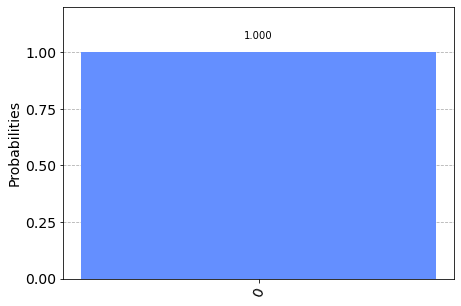

In [21]:
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts())

In [22]:
_plot(result.data()['snapshots']['statevector']['1'])

NameError: name '_plot' is not defined

In [60]:
from qiskit.extensions import UnitaryGate
def multiplexer(qc, gate_list, ctrl_Q, target_Q):
    for i in range(len(gate_list)):
        ug = UnitaryGate(gate_list[i], label=f'Data_{i}')
        qc.append(ug.control(len(ctrl_Q), ctrl_state=i), qargs=[qc.qubits[n] for n in ctrl_Q]+[qc.qubits[target_Q]])

In [85]:
from matplotlib import pyplot as plt
def _plot(array):
    plt.plot([np.abs(a)**2 for a in array])

In [184]:
array = result.data()['snapshots']['statevector']['1']
def _plot(array):
    plt.plot(np.abs(array).flatten()**2)
    plt.ylim([0, 1])

In [30]:
from qasvm.circuits.classifier import QASVM, BlochSphereQASVM, UniformBlochQASVM, UniformQASVM
from qiskit import transpile
qasvm = BlochSphereQASVM(var_form = var_form, training_data = X, training_label = y, optimizer = opt, quantum_instance = qi).dual
transpile(qasvm.second_order_circuit, basis_gates = ['rx', 'ry', 'rz', 'cx']).depth()

72

In [31]:
qasvm.run()
qasvm.accuracy(X, y)

0.0

In [37]:
qasvm = UniformBlochQASVM(training_data = X, training_label = y, quantum_instance=qi)
qasvm.run()
qasvm.classifier_circuit.draw()

┌───┐                                            ┌───┐┌─┐
 a_0: ───────┤ H ├──────────────────────────────────────────■─┤ H ├┤M├
             ├───┤       ┌──────────────┐┌────────────────┐ │ └───┘└╥┘
 i_0: ───────┤ H ├───────┤1             ├┤1               ├─┼───────╫─
             ├───┤       │              ││                │ │       ║ 
 i_1: ───────┤ H ├───────┤2 MULTIPLEXER ├┤2               ├─┼───────╫─
             └───┘       │              ││  UCRX(π,π,π,π) │ │       ║ 
xi_0: ───────────────────┤0             ├┤                ├─X───────╫─
                         └──────────────┘│                │ │  ┌─┐  ║ 
yi_0: ───────────────────────────────────┤0               ├─┼──┤M├──╫─
      ┌─────────────────┐                └────────────────┘ │  └╥┘  ║ 
xj_0: ┤ U3(𝒳[0],𝒳[1],0) ├───────────────────────────────────X───╫───╫─
      └─────────────────┘                                       ║   ║ 
 c: 2/══════════════════════════════════════════════════════════╩═══╩═
                                                                1   0

In [23]:
qasvm.f(X)

array([8.93066406, 7.83569336, 7.93273926, 8.48083496])